# Alzheimer prediction based on numerical data 

## Summary

In this Notebook the numerical data which is provided by the OASIS-1 dataset (https://www.oasis-brains.org) will be used as input for different classifiers with the aim to predict Alzheimer's disease. Further, the dataset for ADNI-1 will be used in the second part for the same classifier and the performance compared to the OASIS-1 dataset. In the last section, both datasets will be combined and used to predict Alzheimers. 

**NOTE**: In this notebook we will only predict healthy (= 0) and AD (=1), so it is a binary classification problem. 

### The datasets 

The OASIS-1 dataset consists of 416 subjects, of which 316 were diagnosed as being non-demented (CDR = 0, control group) and 100 with being demented ranging from very mild dementia (0.5), mild dementia (1) to moderate dementia (2). The ADNI-1 dataset contains 831 subjects. 



In [1]:
# Import all the required packages 

# Import all the required packages for data analysis and the EDA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import os
import matplotlib.patches as mpatches
from numpy import isnan
import sys
sys.path.append('../')

#Import packages for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

np.random.seed(42)

In [2]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from tadpole_challenge.config_tp import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

In [3]:
# Load functions to get the dataset and process it 
from preprocessing.getdata import get_csvdata, get_tadpole, drop_tadpole, col_tadpole

### Part 1 - The OASIS dataset 

For extended EDA of this dataset have a look into the OASIS_1_EDA_numeric.

In [4]:
#Import the dataset

df_oasis=get_csvdata(drop_young=False, drop_contradictions=False)
df_oasis.head(10)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,1,1454,0.708,1.207
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,0,1588,0.803,1.105
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,0,1737,0.848,1.010
5,OAS1_0006_MR1,F,24,NaN,NaN,NaN,0,1131,0.862,1.551
6,OAS1_0007_MR1,M,21,NaN,NaN,NaN,0,1516,0.830,1.157
7,OAS1_0009_MR1,F,20,NaN,NaN,NaN,0,1505,0.843,1.166
8,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0,1636,0.689,1.073
9,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0,1321,0.827,1.329


In [5]:
df_oasis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Age     436 non-null    int64  
 3   Educ    235 non-null    float64
 4   SES     216 non-null    float64
 5   MMSE    235 non-null    float64
 6   CDR     436 non-null    int64  
 7   eTIV    436 non-null    int64  
 8   nWBV    436 non-null    float64
 9   ASF     436 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 34.2+ KB


In [6]:
#For the modeling, we do not need the ID column since it does not hold any information for the prediction 
df_oasis.drop(columns=['ID'], inplace=True, axis=1)

#Create dummies for the gender column 

df_oasis=pd.get_dummies(df_oasis, columns=['M/F'], drop_first=False)

In [7]:
# Let us check how many missing values we have 
df_oasis.isnull().sum()

Age        0
Educ     201
SES      220
MMSE     201
CDR        0
eTIV       0
nWBV       0
ASF        0
M/F_F      0
M/F_M      0
dtype: int64

In [8]:
#Perform train-test split 
X= df_oasis.drop('CDR', axis=1)
y=df_oasis['CDR']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [9]:
#There are only missing values in the Education, Socioeconomic and MMSE column 
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [10]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 1.1 SVM

In [11]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='1_oasis_trans_scaled_SVM')
run = mlflow.active_run()

In [12]:
# Define hyperparameter grid for SVM
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='accuracy', verbose=1)

In [13]:
# Print best parameters 
print('Best Parameters:', gs.best_params_)

Best Parameters: {'C': 100, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


In [14]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [15]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.9480122324159022
The accuracy on the test dataset is 0.8256880733944955


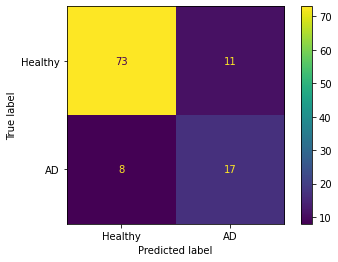

In [16]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [17]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        84
           1       0.61      0.68      0.64        25

    accuracy                           0.83       109
   macro avg       0.75      0.77      0.76       109
weighted avg       0.83      0.83      0.83       109



In [18]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.8256880733944955, 'train-accuracy': 0.9480122324159022}, params={}, tags={'mlflow.runName': '1_oasis_trans_scaled_SVM',
 'mlflow.source.git.commit': '97b344c7edff97de979d36e64b24b93c49292d8f',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/8b2ab6da5d0f4ca08c58bf4d8a694377/artifacts', end_time=1662035053460, experiment_id='56', lifecycle_stage='active', run_id='8b2ab6da5d0f4ca08c58bf4d8a694377', run_uuid='8b2ab6da5d0f4ca08c58bf4d8a694377', start_time=1662035047432, status='FINISHED', user_id='tamarapallien'>>

#### 1.2 ExtraTreeClassifier 

In [19]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='2_oasis_trans_scaled_Xtree')
run = mlflow.active_run()

In [20]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.939 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.864 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.862 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.938 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.846 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.969 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.831 total time=   0.1s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 200}

In [21]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [22]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.9296636085626911
The accuracy on the test dataset is 0.8807339449541285


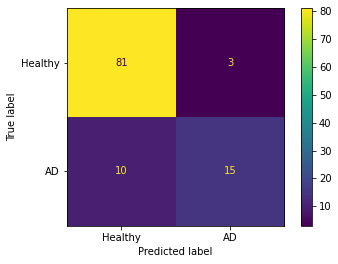

In [23]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [24]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93        84
           1       0.83      0.60      0.70        25

    accuracy                           0.88       109
   macro avg       0.86      0.78      0.81       109
weighted avg       0.88      0.88      0.87       109



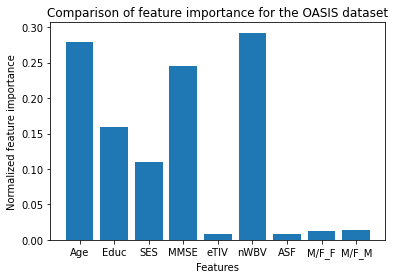

In [25]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized)
plt.xlabel('Features')
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the OASIS dataset')
plt.show()                      

In [26]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.8807339449541285, 'train-accuracy': 0.9296636085626911}, params={}, tags={'mlflow.runName': '2_oasis_trans_scaled_Xtree',
 'mlflow.source.git.commit': '97b344c7edff97de979d36e64b24b93c49292d8f',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/deea043215ae406dac01ece501fc307e/artifacts', end_time=1662035054648, experiment_id='56', lifecycle_stage='active', run_id='deea043215ae406dac01ece501fc307e', run_uuid='deea043215ae406dac01ece501fc307e', start_time=1662035053685, status='FINISHED', user_id='tamarapallien'>>

### Part 2 - The ADNI dataset 

In [27]:
#Import the dataset

df_adni=get_tadpole()
df_adni.head(10)

/var/folders/v3/9m4l768x37nbr7_d_v6t2fhm0000gn/T/ipykernel_99494/1707069863.py:3: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  df_adni=get_tadpole()


,RID,ID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,label
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,1.36665,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,22.83,1.08355,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
10,5,011_S_0005,bl,11,ADNI1,ADNI1,2005-09-07,CN,73.7,Male,...,33.43,1.29343,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
20,7,022_S_0007,bl,22,ADNI1,ADNI1,2005-10-06,AD,75.4,Male,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
22,10,011_S_0010,bl,11,ADNI1,ADNI1,2005-11-10,AD,73.9,Female,...,31.26,1.11532,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
26,14,022_S_0014,bl,22,ADNI1,ADNI1,2005-11-04,CN,78.5,Female,...,16.68,1.25096,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
31,15,100_S_0015,bl,100,ADNI1,ADNI1,2005-10-18,CN,80.8,Male,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
34,16,011_S_0016,bl,11,ADNI1,ADNI1,2005-10-13,CN,65.4,Male,...,15.88,1.38702,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
39,21,011_S_0021,bl,11,ADNI1,ADNI1,2005-10-24,CN,72.6,Female,...,NaN,1.37788,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
43,23,011_S_0023,bl,11,ADNI1,ADNI1,2005-11-08,CN,71.7,Male,...,16.74,1.36097,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0


In [28]:
# Let us check how many different IDs we have to make sure that we do not have the same person in test and train 
df_adni.nunique()

RID             417
ID              417
VISCODE           1
SITE             56
COLPROT           1
               ... 
Month_bl          1
Month             1
M                 1
update_stamp     10
label             2
Length: 114, dtype: int64

In [29]:
# As the next step we remove all the columns that we do not need for our modeling 
df_adni=drop_tadpole(df_adni)
df_adni.head(2)

,ID,AGE,PTGENDER,PTEDUCAT,APOE4,ABETA,TAU,PTAU,ADAS11,ADAS13,MMSE,RAVLT_immediate,Ventricles,Hippocampus,WholeBrain,Entorhinal,label
0,011_S_0002,74.3,Male,16,0.0,NaN,NaN,NaN,10.67,18.67,28.0,44.0,118233.0,8336.0,1229740.0,4177.0,0
1,011_S_0003,81.3,Male,18,1.0,741.5,239.7,22.83,22.00,31.00,20.0,22.0,84599.0,5319.0,1129830.0,1791.0,1


In [30]:
df_adni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 13134
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               417 non-null    object 
 1   AGE              417 non-null    float64
 2   PTGENDER         417 non-null    object 
 3   PTEDUCAT         417 non-null    int64  
 4   APOE4            417 non-null    float64
 5   ABETA            209 non-null    object 
 6   TAU              209 non-null    object 
 7   PTAU             209 non-null    object 
 8   ADAS11           416 non-null    float64
 9   ADAS13           412 non-null    float64
 10  MMSE             417 non-null    float64
 11  RAVLT_immediate  413 non-null    float64
 12  Ventricles       410 non-null    float64
 13  Hippocampus      345 non-null    float64
 14  WholeBrain       413 non-null    float64
 15  Entorhinal       345 non-null    float64
 16  label            417 non-null    int64  
dtypes: float64(10)

In [31]:
df_adni.isnull().sum()

ID                   0
AGE                  0
PTGENDER             0
PTEDUCAT             0
APOE4                0
ABETA              208
TAU                208
PTAU               208
ADAS11               1
ADAS13               5
MMSE                 0
RAVLT_immediate      4
Ventricles           7
Hippocampus         72
WholeBrain           4
Entorhinal          72
label                0
dtype: int64

In [32]:
#For the modeling, we do not need the ID column since it does not hold any information for the prediction 
df_adni.drop(columns=['ID'], inplace=True, axis=1)

#Create dummies for the gender column 

df_adni=pd.get_dummies(df_adni, columns=['PTGENDER'], drop_first=False)

In [33]:
df_adni=col_tadpole(df_adni)
df_adni

,AGE,PTEDUCAT,APOE4,ABETA,TAU,PTAU,ADAS11,ADAS13,MMSE,RAVLT_immediate,Ventricles,Hippocampus,WholeBrain,Entorhinal,label,PTGENDER_Female,PTGENDER_Male
0,74.3,16,0.0,NaN,NaN,NaN,10.67,18.67,28.0,44.0,118233.0,8336.0,1229740.0,4177.0,0,0,1
1,81.3,18,1.0,741.5,239.7,22.83,22.00,31.00,20.0,22.0,84599.0,5319.0,1129830.0,1791.0,1,0,1
10,73.7,16,0.0,547.3,337.0,33.43,8.67,14.67,29.0,37.0,34062.0,7075.0,1116630.0,4433.0,0,0,1
20,75.4,10,1.0,NaN,NaN,NaN,27.33,40.33,20.0,17.0,25704.0,6729.0,875798.0,2050.0,1,0,1
22,73.9,12,1.0,357.4,329.9,31.26,12.33,24.33,24.0,20.0,26820.0,5485.0,1033540.0,2676.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,72.9,14,0.0,NaN,246.7,20.77,3.67,5.67,29.0,41.0,40569.0,7703.0,1137260.0,4381.0,0,0,1
13124,64.3,16,1.0,314.7,NaN,NaN,42.67,54.67,24.0,10.0,79862.0,NaN,962038.0,NaN,1,0,1
13127,76.7,19,1.0,390.9,NaN,NaN,7.33,11.33,29.0,42.0,41876.0,6986.0,900318.0,4488.0,0,1,0
13133,76.1,16,0.0,529.3,NaN,NaN,5.00,8.00,30.0,50.0,32593.0,5264.0,746249.0,3294.0,0,1,0


In [34]:
df_adni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 13134
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              417 non-null    float64
 1   PTEDUCAT         417 non-null    int64  
 2   APOE4            417 non-null    float64
 3   ABETA            185 non-null    object 
 4   TAU              205 non-null    object 
 5   PTAU             205 non-null    object 
 6   ADAS11           416 non-null    float64
 7   ADAS13           412 non-null    float64
 8   MMSE             417 non-null    float64
 9   RAVLT_immediate  413 non-null    float64
 10  Ventricles       410 non-null    float64
 11  Hippocampus      345 non-null    float64
 12  WholeBrain       413 non-null    float64
 13  Entorhinal       345 non-null    float64
 14  label            417 non-null    int64  
 15  PTGENDER_Female  417 non-null    uint8  
 16  PTGENDER_Male    417 non-null    uint8  
dtypes: float64(10)

In [35]:
#Perform train-test split 
X= df_adni.drop('label', axis=1)
y=df_adni['label']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [36]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [37]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 2.1 SVM with Adni dataset 

In [38]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='3_adni_trans_scaled_SVM')
run = mlflow.active_run()

In [39]:
# Define hyperparameter grid for SVM
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='accuracy', verbose=1)

In [40]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [41]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy of the adni on the training set is {acc_train}')
print(f'The accuracy of the adni on the test dataset is {acc_test}')

The accuracy of the adni on the training set is 1.0
The accuracy of the adni on the test dataset is 0.9904761904761905


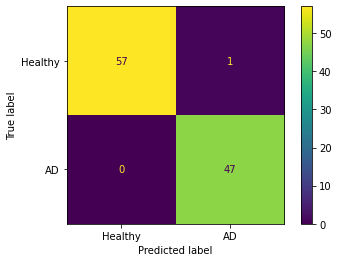

In [42]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [43]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        47

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



In [44]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.9904761904761905, 'train-accuracy': 1.0}, params={}, tags={'mlflow.runName': '3_adni_trans_scaled_SVM',
 'mlflow.source.git.commit': '97b344c7edff97de979d36e64b24b93c49292d8f',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/2444cc1cd7674ca5917a0fa937aa9cbf/artifacts', end_time=1662035057793, experiment_id='56', lifecycle_stage='active', run_id='2444cc1cd7674ca5917a0fa937aa9cbf', run_uuid='2444cc1cd7674ca5917a0fa937aa9cbf', start_time=1662035055959, status='FINISHED', user_id='tamarapallien'>>

#### 2.2 ExtraTreeClassifier on the Adni dataset 

In [45]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='4_adni_trans_scaled_Xtree')
run = mlflow.active_run()

In [46]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.984 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.984 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.984 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=1.000 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.984 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.984 total time=   0.1s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 100}

In [47]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [48]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.9967948717948718
The accuracy on the test dataset is 1.0


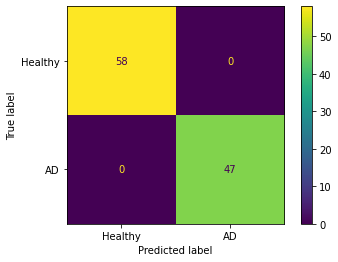

In [49]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [50]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        47

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



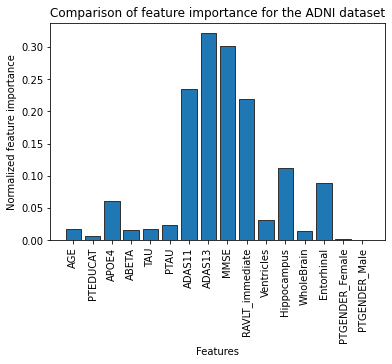

In [51]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

In [52]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 1.0, 'train-accuracy': 0.9967948717948718}, params={}, tags={'mlflow.runName': '4_adni_trans_scaled_Xtree',
 'mlflow.source.git.commit': '97b344c7edff97de979d36e64b24b93c49292d8f',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/ff0e3172df2c41149a7af1d7b59f154d/artifacts', end_time=1662035059141, experiment_id='56', lifecycle_stage='active', run_id='ff0e3172df2c41149a7af1d7b59f154d', run_uuid='ff0e3172df2c41149a7af1d7b59f154d', start_time=1662035057995, status='FINISHED', user_id='tamarapallien'>>

#### 3. Merge the two datasets 

We can see in our plot above that especially for the ADNI dataset, there is a huge influence of the cognitive tests on the prediction of Alzheimer's disease. For the next section, we will combine the ADNI and OASIS dataset, leaving out the cognitive tests to avoid to high importance. 

In [53]:
#Let us find out how we can combine the two datasets
print(df_adni.columns)
print(df_oasis.columns)

Index(['AGE', 'PTEDUCAT', 'APOE4', 'ABETA', 'TAU', 'PTAU', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'label', 'PTGENDER_Female', 'PTGENDER_Male'],
      dtype='object')
Index(['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'M/F_F',
       'M/F_M'],
      dtype='object')


We can see that we have quite some columns in common. To be able to put the dataframe together, we would need to rename the 'CDR' in the OASIS dataset with 'label' and the gender columns. Further, for both dataframes we will drop the columns with the cognitive tests. 

In [54]:
#Rename the columns in the Oasis dataframe 
df_oasis.rename(columns={'CDR':'label', 'M/F_F':'Female', 'M/F_M':'Male'}, inplace=True)
df_oasis

,Age,Educ,SES,MMSE,label,eTIV,nWBV,ASF,Female,Male
0,74,2.0,3.0,29.0,0,1344,0.743,1.306,1,0
1,55,4.0,1.0,29.0,0,1147,0.810,1.531,1,0
2,73,4.0,3.0,27.0,1,1454,0.708,1.207,1,0
3,28,NaN,NaN,NaN,0,1588,0.803,1.105,0,1
4,18,NaN,NaN,NaN,0,1737,0.848,1.010,0,1
...,...,...,...,...,...,...,...,...,...,...
431,20,NaN,NaN,NaN,0,1469,0.847,1.195,0,1
432,22,NaN,NaN,NaN,0,1684,0.790,1.042,0,1
433,22,NaN,NaN,NaN,0,1580,0.856,1.111,0,1
434,20,NaN,NaN,NaN,0,1262,0.861,1.390,1,0


In [55]:
#Rename the columns in the ADNI dataframe 
df_adni.rename(columns={'PTGENDER_Female':'Female', 'PTGENDER_Male':'Male', 'AGE':'Age'}, inplace=True)
df_adni

,Age,PTEDUCAT,APOE4,ABETA,TAU,PTAU,ADAS11,ADAS13,MMSE,RAVLT_immediate,Ventricles,Hippocampus,WholeBrain,Entorhinal,label,Female,Male
0,74.3,16,0.0,NaN,NaN,NaN,10.67,18.67,28.0,44.0,118233.0,8336.0,1229740.0,4177.0,0,0,1
1,81.3,18,1.0,741.5,239.7,22.83,22.00,31.00,20.0,22.0,84599.0,5319.0,1129830.0,1791.0,1,0,1
10,73.7,16,0.0,547.3,337.0,33.43,8.67,14.67,29.0,37.0,34062.0,7075.0,1116630.0,4433.0,0,0,1
20,75.4,10,1.0,NaN,NaN,NaN,27.33,40.33,20.0,17.0,25704.0,6729.0,875798.0,2050.0,1,0,1
22,73.9,12,1.0,357.4,329.9,31.26,12.33,24.33,24.0,20.0,26820.0,5485.0,1033540.0,2676.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,72.9,14,0.0,NaN,246.7,20.77,3.67,5.67,29.0,41.0,40569.0,7703.0,1137260.0,4381.0,0,0,1
13124,64.3,16,1.0,314.7,NaN,NaN,42.67,54.67,24.0,10.0,79862.0,NaN,962038.0,NaN,1,0,1
13127,76.7,19,1.0,390.9,NaN,NaN,7.33,11.33,29.0,42.0,41876.0,6986.0,900318.0,4488.0,0,1,0
13133,76.1,16,0.0,529.3,NaN,NaN,5.00,8.00,30.0,50.0,32593.0,5264.0,746249.0,3294.0,0,1,0


In [56]:
# We use the pandas concatenate function to merge the two dataframes 
df_merge = pd.concat([df_adni, df_oasis])
df_merge

,Age,PTEDUCAT,APOE4,ABETA,TAU,PTAU,ADAS11,ADAS13,MMSE,RAVLT_immediate,...,WholeBrain,Entorhinal,label,Female,Male,Educ,SES,eTIV,nWBV,ASF
0,74.3,16.0,0.0,NaN,NaN,NaN,10.67,18.67,28.0,44.0,...,1229740.0,4177.0,0,0,1,NaN,NaN,NaN,NaN,NaN
1,81.3,18.0,1.0,741.5,239.7,22.83,22.00,31.00,20.0,22.0,...,1129830.0,1791.0,1,0,1,NaN,NaN,NaN,NaN,NaN
10,73.7,16.0,0.0,547.3,337.0,33.43,8.67,14.67,29.0,37.0,...,1116630.0,4433.0,0,0,1,NaN,NaN,NaN,NaN,NaN
20,75.4,10.0,1.0,NaN,NaN,NaN,27.33,40.33,20.0,17.0,...,875798.0,2050.0,1,0,1,NaN,NaN,NaN,NaN,NaN
22,73.9,12.0,1.0,357.4,329.9,31.26,12.33,24.33,24.0,20.0,...,1033540.0,2676.0,1,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,1,NaN,NaN,1469.0,0.847,1.195
432,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,1,NaN,NaN,1684.0,0.790,1.042
433,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,1,NaN,NaN,1580.0,0.856,1.111
434,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0,NaN,NaN,1262.0,0.861,1.390


In [57]:
df_merge.isnull().sum()

Age                  0
PTEDUCAT           436
APOE4              436
ABETA              668
TAU                648
PTAU               648
ADAS11             437
ADAS13             441
MMSE               201
RAVLT_immediate    440
Ventricles         443
Hippocampus        508
WholeBrain         440
Entorhinal         508
label                0
Female               0
Male                 0
Educ               618
SES                637
eTIV               417
nWBV               417
ASF                417
dtype: int64

In [58]:
#We will drop the columns with the cognitive tests and also the one with the education. 
col = ['PTEDUCAT', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'Educ', 'ASF', 'SES']
df_merge.drop(columns=col, axis=1, inplace=True)

In [59]:
df_merge.isnull().sum()

Age              0
APOE4          436
ABETA          668
TAU            648
PTAU           648
Ventricles     443
Hippocampus    508
WholeBrain     440
Entorhinal     508
label            0
Female           0
Male             0
eTIV           417
nWBV           417
dtype: int64

In [60]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 435
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          853 non-null    float64
 1   APOE4        417 non-null    float64
 2   ABETA        185 non-null    object 
 3   TAU          205 non-null    object 
 4   PTAU         205 non-null    object 
 5   Ventricles   410 non-null    float64
 6   Hippocampus  345 non-null    float64
 7   WholeBrain   413 non-null    float64
 8   Entorhinal   345 non-null    float64
 9   label        853 non-null    int64  
 10  Female       853 non-null    uint8  
 11  Male         853 non-null    uint8  
 12  eTIV         436 non-null    float64
 13  nWBV         436 non-null    float64
dtypes: float64(8), int64(1), object(3), uint8(2)
memory usage: 88.3+ KB


In [61]:
df_merge[['ABETA', 'TAU', 'PTAU']].astype(float)

,ABETA,TAU,PTAU
0,NaN,NaN,NaN
1,741.5,239.7,22.83
10,547.3,337.0,33.43
20,NaN,NaN,NaN
22,357.4,329.9,31.26
...,...,...,...
431,NaN,NaN,NaN
432,NaN,NaN,NaN
433,NaN,NaN,NaN
434,NaN,NaN,NaN


In [62]:
#We will now use the KNN imputer to predict the missing values in the dataframe 
#Perform train-test split 
X= df_merge.drop('label', axis=1)
y=df_merge['label']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)


In [63]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [64]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 3.1 Extra Tree Classifier on the merged dataset without the cognitive test results 

In [65]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='5_merge_trans_scaled_Xtree')
run = mlflow.active_run()

In [66]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.844 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.812 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.828 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.820 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.795 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.812 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.844 total time=   0.1s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 50}

In [67]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [68]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.8482003129890454
The accuracy on the test dataset is 0.7850467289719626


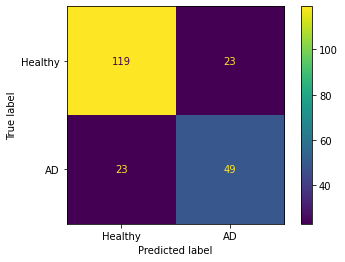

In [69]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [70]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       142
           1       0.68      0.68      0.68        72

    accuracy                           0.79       214
   macro avg       0.76      0.76      0.76       214
weighted avg       0.79      0.79      0.79       214



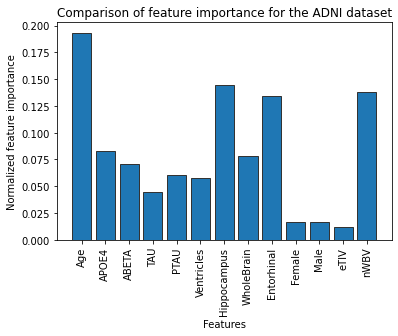

In [71]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

When we pool both dataframes and take out the cognitive tests, the model is performing much worse. Further, we also had many empty rows that we were predicting using the Imputer. Since we do not really now how good this is working, it might also cause some errors. In the last section, we will analyze what kind of errors our model is doing. 

In [72]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.7850467289719626, 'train-accuracy': 0.8482003129890454}, params={}, tags={'mlflow.runName': '5_merge_trans_scaled_Xtree',
 'mlflow.source.git.commit': '97b344c7edff97de979d36e64b24b93c49292d8f',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/0fddfcc0e38444379245cc76c9d63614/artifacts', end_time=1662035061577, experiment_id='56', lifecycle_stage='active', run_id='0fddfcc0e38444379245cc76c9d63614', run_uuid='0fddfcc0e38444379245cc76c9d63614', start_time=1662035060315, status='FINISHED', user_id='tamarapallien'>>

#### 4. Error Analysis for the merged dataset

For the error analysis we will add the y_pred to our X_test dataframe.  

In [73]:
#Convert X_test into a dataframe 
df_ea = pd.DataFrame(X_test)
df_ea

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,51.0,0.8,514.90,384.12,37.186,20192.0,6473.4,957933.8,3243.6,0.0,1.0,1538.0,0.8310
1,21.0,0.8,514.90,384.12,37.186,20192.0,6822.4,957933.8,3222.6,0.0,1.0,1689.0,0.8450
2,84.8,1.0,888.10,355.20,34.730,39130.0,7068.0,1076350.0,3619.0,0.0,1.0,1454.4,0.7064
3,78.1,1.0,453.40,336.92,33.374,40820.0,4785.8,820032.0,2395.8,1.0,0.0,1344.8,0.7242
4,18.0,1.0,753.34,346.60,32.962,45628.0,6473.4,919157.8,3243.6,1.0,0.0,1633.0,0.8590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,78.0,0.4,681.60,244.72,24.840,24795.8,6412.2,942237.4,2882.0,1.0,0.0,1461.0,0.7150
210,77.0,0.6,622.94,228.86,22.674,54190.0,7085.6,1046589.2,3518.6,0.0,1.0,1818.0,0.7360
211,22.0,0.8,514.90,384.12,37.186,20192.0,6822.4,957933.8,3222.6,0.0,1.0,1799.0,0.8650
212,26.0,1.0,753.34,346.60,32.962,45628.0,6822.4,919157.8,3222.6,1.0,0.0,1288.0,0.7770


In [74]:
#Assign column names to the dataframe 
colum_names = ['Age', 'Apoe4', 'Abeta', 'Tau', 'pTau', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Enthorinal', 'Female', 'Male', 'eTIV', 'nWBV']
df_ea.columns = colum_names
df_ea

,Age,Apoe4,Abeta,Tau,pTau,Ventricles,Hippocampus,WholeBrain,Enthorinal,Female,Male,eTIV,nWBV
0,51.0,0.8,514.90,384.12,37.186,20192.0,6473.4,957933.8,3243.6,0.0,1.0,1538.0,0.8310
1,21.0,0.8,514.90,384.12,37.186,20192.0,6822.4,957933.8,3222.6,0.0,1.0,1689.0,0.8450
2,84.8,1.0,888.10,355.20,34.730,39130.0,7068.0,1076350.0,3619.0,0.0,1.0,1454.4,0.7064
3,78.1,1.0,453.40,336.92,33.374,40820.0,4785.8,820032.0,2395.8,1.0,0.0,1344.8,0.7242
4,18.0,1.0,753.34,346.60,32.962,45628.0,6473.4,919157.8,3243.6,1.0,0.0,1633.0,0.8590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,78.0,0.4,681.60,244.72,24.840,24795.8,6412.2,942237.4,2882.0,1.0,0.0,1461.0,0.7150
210,77.0,0.6,622.94,228.86,22.674,54190.0,7085.6,1046589.2,3518.6,0.0,1.0,1818.0,0.7360
211,22.0,0.8,514.90,384.12,37.186,20192.0,6822.4,957933.8,3222.6,0.0,1.0,1799.0,0.8650
212,26.0,1.0,753.34,346.60,32.962,45628.0,6822.4,919157.8,3222.6,1.0,0.0,1288.0,0.7770


In [75]:
#Add the test values and the predicted values to the dataframe 

df_ea['y_test'] = y_test.values
df_ea['y_pred'] = y_pred_tuned
df_ea

,Age,Apoe4,Abeta,Tau,pTau,Ventricles,Hippocampus,WholeBrain,Enthorinal,Female,Male,eTIV,nWBV,y_test,y_pred
0,51.0,0.8,514.90,384.12,37.186,20192.0,6473.4,957933.8,3243.6,0.0,1.0,1538.0,0.8310,0,0
1,21.0,0.8,514.90,384.12,37.186,20192.0,6822.4,957933.8,3222.6,0.0,1.0,1689.0,0.8450,0,0
2,84.8,1.0,888.10,355.20,34.730,39130.0,7068.0,1076350.0,3619.0,0.0,1.0,1454.4,0.7064,0,0
3,78.1,1.0,453.40,336.92,33.374,40820.0,4785.8,820032.0,2395.8,1.0,0.0,1344.8,0.7242,0,1
4,18.0,1.0,753.34,346.60,32.962,45628.0,6473.4,919157.8,3243.6,1.0,0.0,1633.0,0.8590,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,78.0,0.4,681.60,244.72,24.840,24795.8,6412.2,942237.4,2882.0,1.0,0.0,1461.0,0.7150,1,0
210,77.0,0.6,622.94,228.86,22.674,54190.0,7085.6,1046589.2,3518.6,0.0,1.0,1818.0,0.7360,0,0
211,22.0,0.8,514.90,384.12,37.186,20192.0,6822.4,957933.8,3222.6,0.0,1.0,1799.0,0.8650,0,0
212,26.0,1.0,753.34,346.60,32.962,45628.0,6822.4,919157.8,3222.6,1.0,0.0,1288.0,0.7770,0,0


In [76]:
# We write a function to add the classification (TP, TN, FP and FN) to our dataframe 
def classification(row): 
    if (row.y_test == 1) & (row.y_pred == 1): 
        return 'TP'
    if (row.y_test ==1 ) & (row.y_pred == 0): 
        return 'FN'
    if (row.y_test == 0) & (row.y_pred == 1):
        return 'FP'
    if (row.y_test == 0) & (row.y_pred == 0): 
        return 'TN'
 

df_ea['classification']=df_ea.apply(lambda row: classification (row), axis=1)

In [77]:
df_ea['classification'].nunique()

4

In [78]:
# We can have a look on our Top 10 wrongly classified entries 
df_ea_fp = df_ea.query('classification == "FP"').head(10)
print(f'An example of 10 false positive (FP) entries are the following: {df_ea_fp}')

An example of 10 false positive (FP) entries are the following:      Age  Apoe4   Abeta     Tau    pTau  Ventricles  Hippocampus  WholeBrain  \
3   78.1    1.0  453.40  336.92  33.374     40820.0       4785.8    820032.0   
5   86.2    0.0  451.78  311.74  31.464     63932.0       5606.0    893814.0   
14  67.0    1.4  543.14  398.22  41.134     47079.6       5591.4   1018739.4   
19  81.0    0.0  637.80  145.40  12.910     49740.6       5677.2    864962.8   
23  84.0    0.8  890.18  327.72  30.866     42414.6       5060.2    842147.8   
31  80.0    0.0  828.90  296.10  28.486     39562.0       5700.0   1051050.0   
39  80.0    0.4  821.94  373.30  37.208     54564.6       5472.8    921372.6   
40  78.2    0.0  633.90  212.28  20.912     87500.0       6444.0   1035850.0   
43  87.2    1.0  935.30  336.90  34.210     56259.8       4944.4    932979.6   
52  84.0    0.6  928.54  316.42  31.604     62080.0       5801.2   1017092.0   

    Enthorinal  Female  Male    eTIV    nWBV  y_test  y

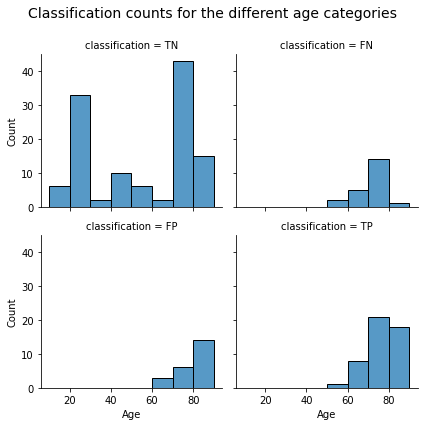

In [79]:
#Plot the classification for the Age 

plot=sns.FacetGrid(data=df_ea, col='classification', col_wrap=2, col_order=['TN', 'FN', 'FP', 'TP'])
plot.map_dataframe(sns.histplot, x='Age', binrange=(10,90), binwidth=10)
plot.fig.subplots_adjust(top=0.87)
plot.fig.suptitle('Classification counts for the different age categories', fontsize=14);

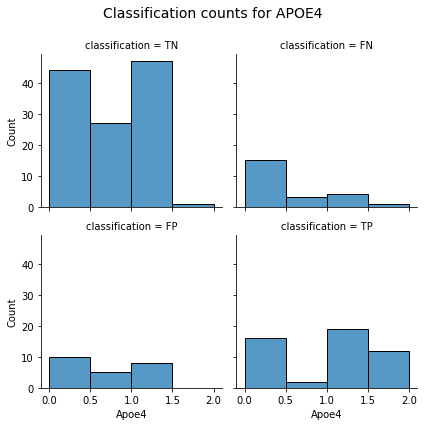

In [80]:
#Plot the classification for the Apoe4

plot=sns.FacetGrid(data=df_ea, col='classification', col_wrap=2, col_order=['TN', 'FN', 'FP', 'TP'])
plot.map_dataframe(sns.histplot, x='Apoe4', binrange=(0,2), binwidth=0.5)
plot.fig.subplots_adjust(top=0.87)
plot.fig.suptitle('Classification counts for APOE4', fontsize=14);

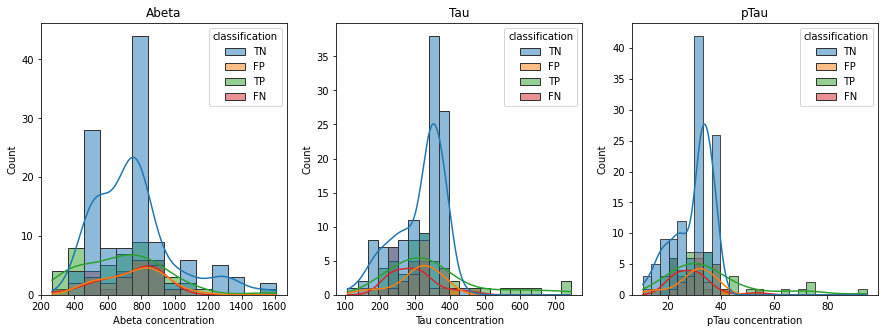

In [81]:
#Plot the classification for the Abeta, Tau and pTau 

#Create plots with all three different categories 
fig, axes = plt.subplots(1,3, figsize=(15,5))

#Abeta
sns.histplot(ax=axes[0],data=df_ea, x='Abeta', edgecolor=".2", hue='classification', kde=True).set(xlabel='Abeta concentration', ylabel='Count')
axes[0].set_title('Abeta');

#Tau
sns.histplot(ax=axes[1],data=df_ea, x='Tau', edgecolor=".2", hue='classification', kde=True).set(xlabel='Tau concentration', ylabel='Count')
axes[1].set_title('Tau');

#pTau
sns.histplot(ax=axes[2],data=df_ea, x='pTau', edgecolor=".2", hue='classification', kde=True).set(xlabel='pTau concentration', ylabel='Count')
axes[2].set_title('pTau');



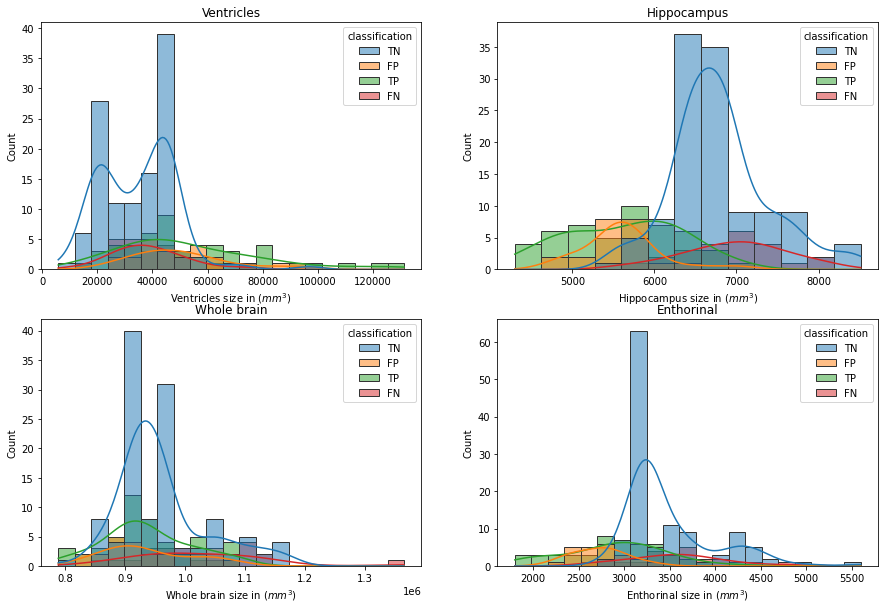

In [82]:
#Plot the classification for the Ventricles, Hippocampus,WholeBrain and	Enthorinal	 

#Create plots with all three different categories 
fig, axes = plt.subplots(2,2, figsize=(15,10))

#Ventricles
sns.histplot(ax=axes[0,0],data=df_ea, x='Ventricles', edgecolor=".2", hue='classification', kde=True).set(xlabel='Ventricles size in ($mm^3$)', ylabel='Count')
axes[0,0].set_title('Ventricles');

#Hippocampus
sns.histplot(ax=axes[0,1],data=df_ea, x='Hippocampus', edgecolor=".2", hue='classification', kde=True).set(xlabel='Hippocampus size in ($mm^3$)', ylabel='Count')
axes[0,1].set_title('Hippocampus');

#Whole Brain
sns.histplot(ax=axes[1,0],data=df_ea, x='WholeBrain', edgecolor=".2", hue='classification', kde=True).set(xlabel='Whole brain size in ($mm^3$)', ylabel='Count')
axes[1,0].set_title('Whole brain');

#Entorhinal
sns.histplot(ax=axes[1,1],data=df_ea, x='Enthorinal', edgecolor=".2", hue='classification', kde=True).set(xlabel='Enthorinal size in ($mm^3$)', ylabel='Count')
axes[1,1].set_title('Enthorinal');

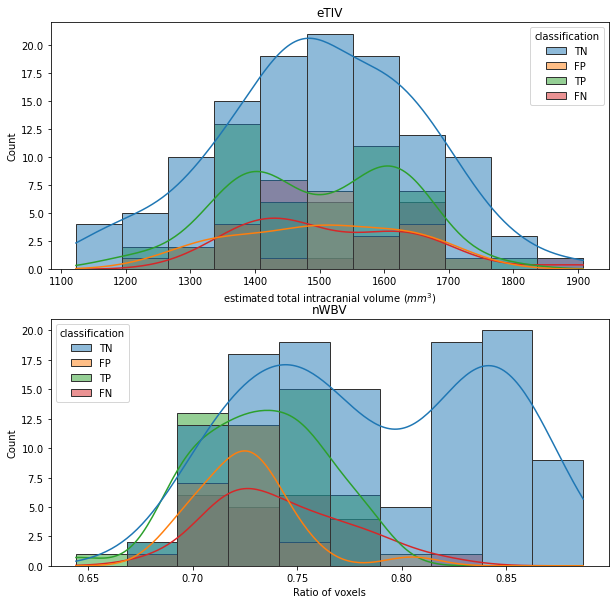

In [83]:
#Plot the classification for the eTIV and nWBV

#Create plots with all three different categories 
fig, axes = plt.subplots(2, figsize=(10,10))

#eTIV
sns.histplot(ax=axes[0],data=df_ea, x='eTIV', edgecolor=".2", hue='classification', kde=True).set(xlabel='estimated total intracranial volume ($mm^3$)', ylabel='Count')
axes[0].set_title('eTIV');

#nWBV
sns.histplot(ax=axes[1],data=df_ea, x='nWBV', edgecolor=".2", hue='classification', kde=True).set(xlabel='Ratio of voxels', ylabel='Count')
axes[1].set_title('nWBV');
